# Aligning two coronal sections of adult mouse brain from MERFISH

In this notebook, we align two single cell resolution spatial transcriptomics datasets of coronal sections of the adult mouse brain from matched locations with respect to bregma assayed by MERFISH.

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [1]:
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [2]:
## skip cell if STalign.py in same folder as notebook
import sys
sys.path.append("../../STalign") 

In [3]:
## import STalign from upper directory
import STalign

We have already downloaded single cell spatial transcriptomics datasets and placed the files in a folder called `merfish_data`.

We can read in the cell information for the first dataset using `pandas` as `pd`.

In [4]:
# Single cell data 1
# read in data
fname = '../merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

                                Unnamed: 0  fov       volume    center_x   
0  158338042824236264719696604356349910479   33   532.778772  617.916619  \
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y  
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810  
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812  
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812  
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812  
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810  


For alignment with `STalign`, we only need the cell centroid information so we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

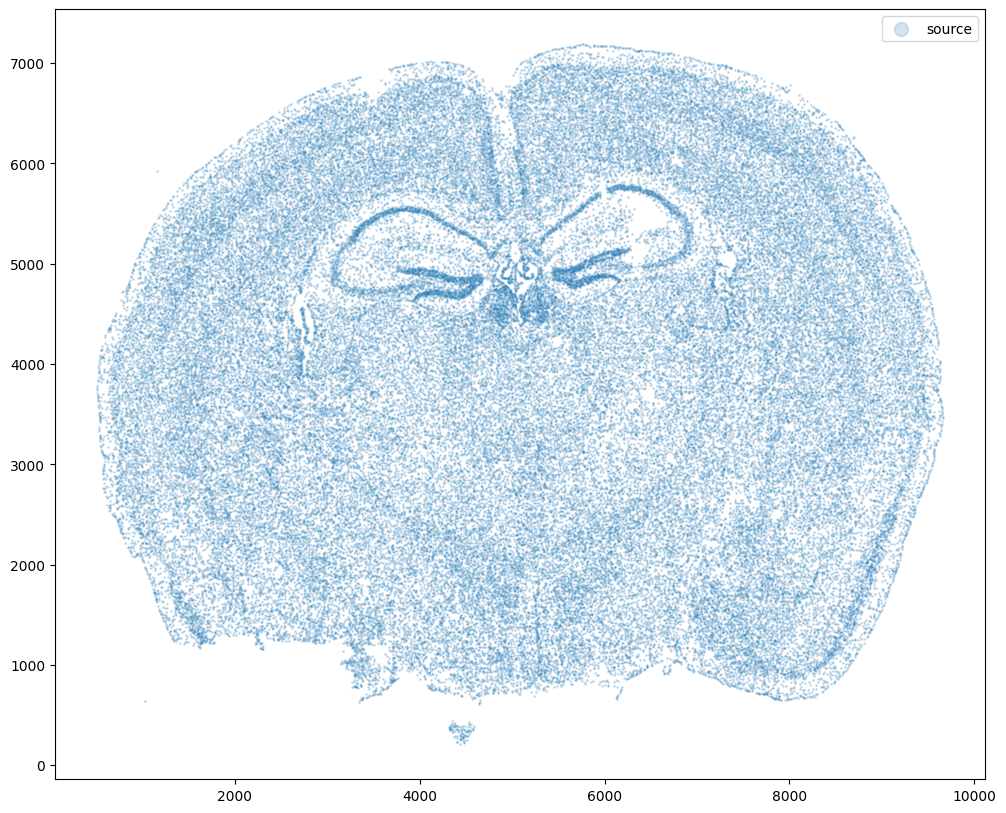

In [5]:
# get cell centroid coordinates
xI = np.array(df1['center_x'])
yI = np.array(df1['center_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2, label='source')
ax.legend(markerscale = 10)

Now, we can repeat this to get cell information from the second dataset.

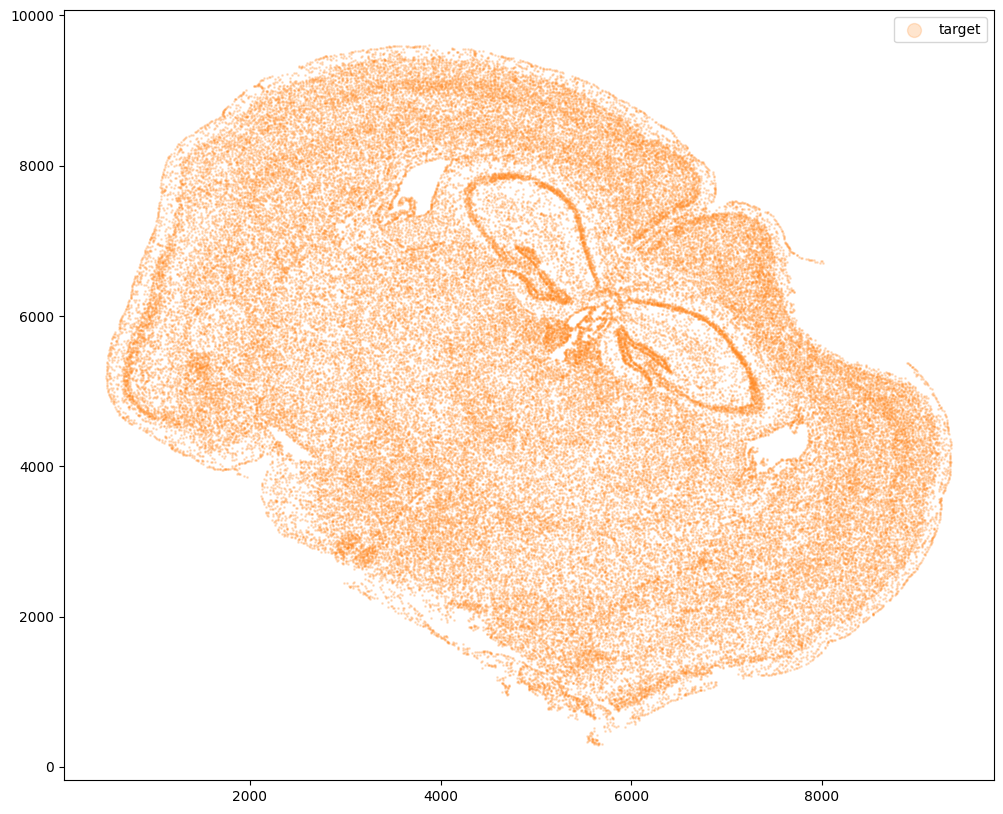

In [6]:
# Single cell data 2
# read in data
fname = '../merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv.gz'

df2 = pd.read_csv(fname)

# get cell centroids
xJ = np.array(df2['center_x'])
yJ = np.array(df2['center_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.2,c='#ff7f0e', label='target')
ax.legend(markerscale = 10)

Note that plotting the cell centroid positions from both datasets shows that non-linear local alignment is needed.

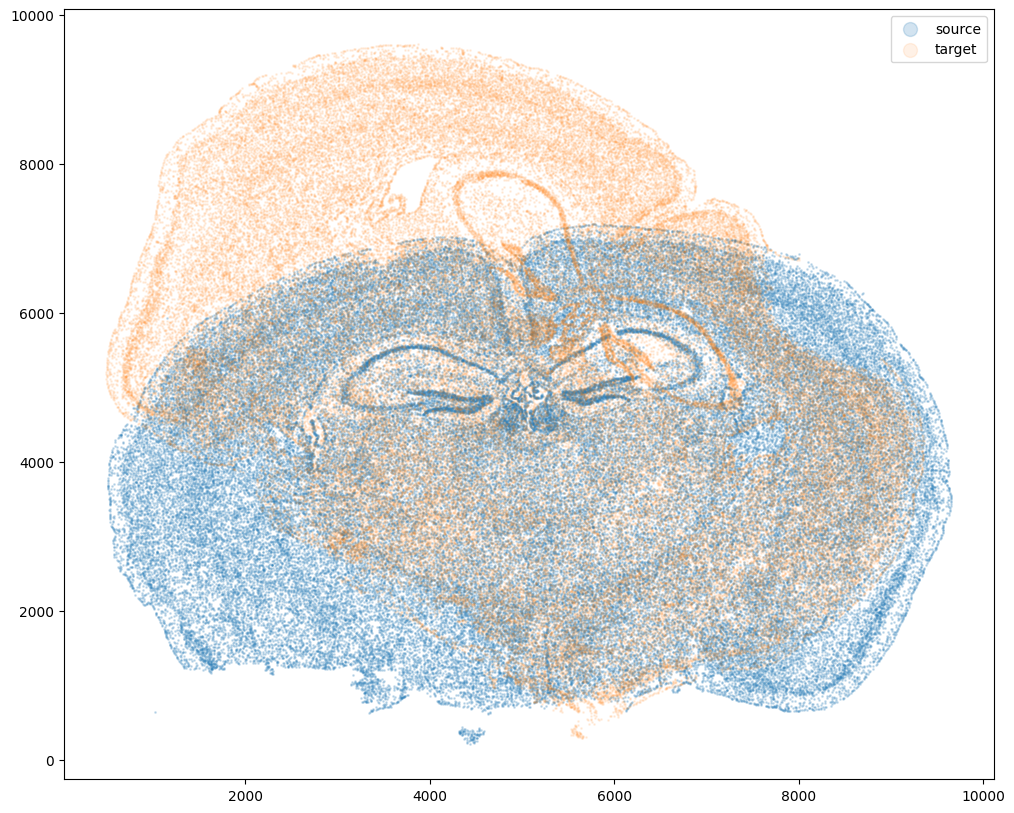

In [7]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2, label='source')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label= 'target')
ax.legend(markerscale = 10)

Now, we will first use `STalign` to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency. 

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


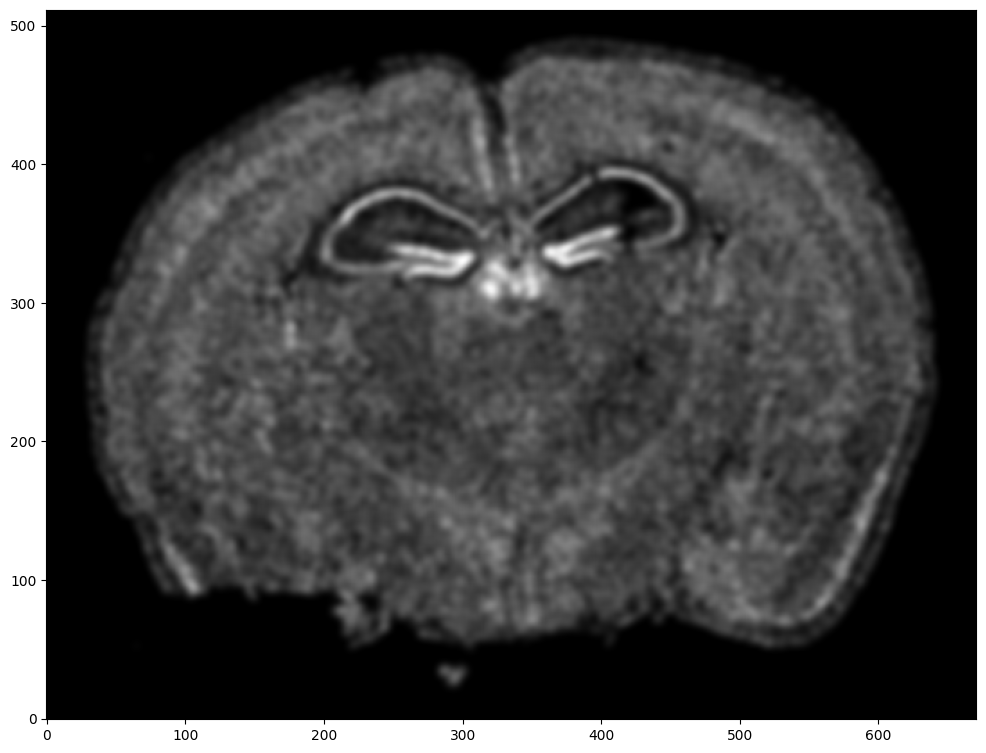

In [8]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=15,blur=1.5)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

Repeat rasterization for target dataset.

0 of 84172
10000 of 84172
20000 of 84172
30000 of 84172
40000 of 84172
50000 of 84172
60000 of 84172
70000 of 84172
80000 of 84172
84171 of 84172


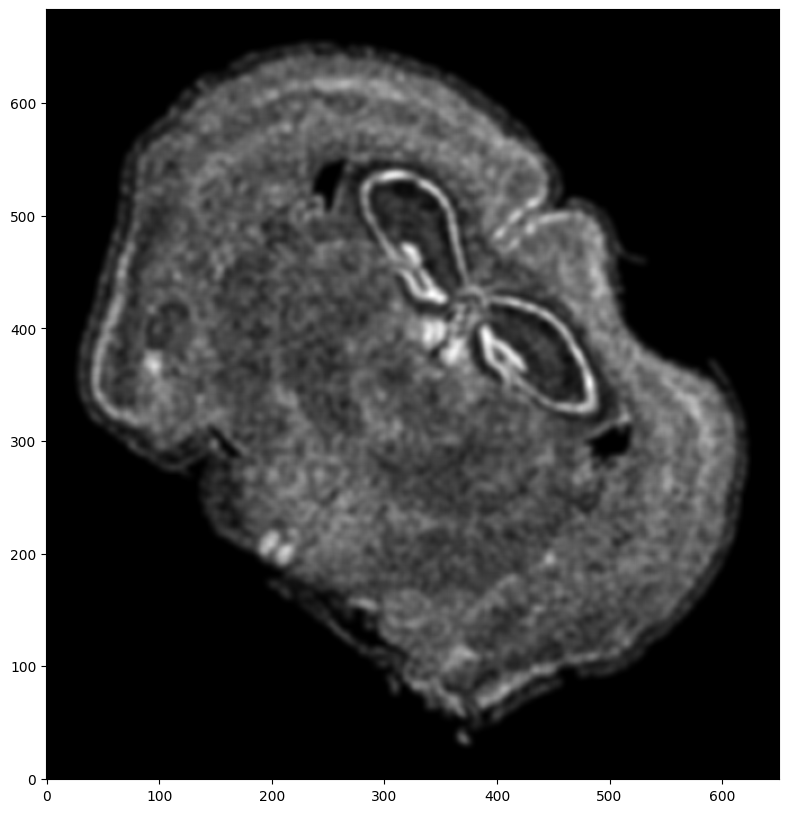

In [9]:
# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=15, blur=1.5)
ax = fig.axes[0]
ax.invert_yaxis()

We can also plot the rasterized images next to each other.

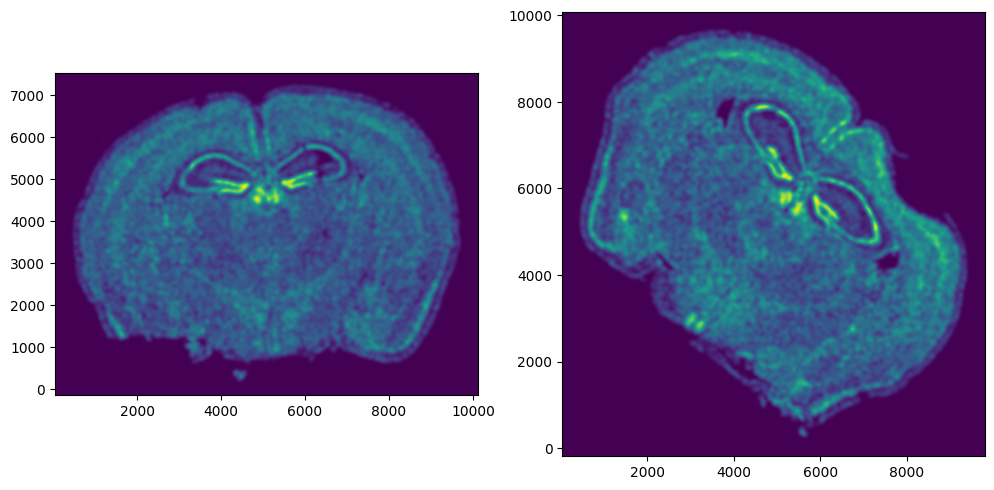

In [10]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(1,2)
ax[0].imshow(I.transpose(1,2,0).squeeze(), extent=extentI) 
ax[1].imshow(J.transpose(1,2,0).squeeze(), extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

We can manually designate a few landmark points to help initialize the alignment. A `point_annotator.py` script is provided to assist with this. In order to use the `point_annotator.py` script, we will need to write out our images as `.npz` files. 

In [11]:
np.savez('../merfish_data/Merfish_S2_R3', x=XI,y=YI,I=I)
np.savez('../merfish_data/Merfish_S2_R2', x=XJ,y=YJ,I=J)

Given these `.npz` files, we can then run the following code on the command line from inside the `notebooks` folder:

```
python ../../STalign/point_annotator.py ../merfish_data/Merfish_S2_R3.npz ../merfish_data/Merfish_S2_R2.npz
```

Which will provide a graphical user interface to selecting points. These points will saved as `Merfish_S2_R3_points.npy` and `Merfish_S2_R2_points.npy` respectively. We can then read in these files. 

In [12]:
# read from file
pointsIlist = np.load('../merfish_data/Merfish_S2_R3_points.npy', allow_pickle=True).tolist()
print(pointsIlist)
pointsJlist = np.load('../merfish_data/Merfish_S2_R2_points.npy', allow_pickle=True).tolist()
print(pointsJlist)

{'all': [(4543.712969822371, 6776.805022223103), (4996.096840790115, 6824.424377061813), (5043.716195628824, 4752.982441577941), (3067.5129698223714, 4872.030828674716), (3900.851679499791, 4776.792118997297), (7019.919421435276, 5205.366312545683), (6091.342002080437, 5014.888893190845), (1543.6936149836606, 3395.830828674716), (3186.561356919145, 3419.6405060940706), (7115.158131112696, 3729.1663125456835), (8519.92909885463, 3038.685667384392), (5258.0032924030165, 2419.6340544811665), (5091.335550467533, 705.3372802876183)]}
{'all': [(6777.380999410521, 7706.03581124174), (7123.880999410521, 7405.73581124174), (5529.9809994105235, 5765.63581124174), (4305.680999410524, 7613.635811241739), (4883.180999410524, 6643.435811241739), (7239.380999410521, 4726.13581124174), (6269.180999410521, 5211.2358112417405), (2249.780999410523, 7475.03581124174), (3289.280999410523, 6158.33581124174), (6615.680999410521, 3247.7358112417405), (6638.780999410523, 2046.5358112417398), (4074.680999410524

Note that these landmark points are read in as lists. We will want to convert them to a simple array for downstream usage. 

In [13]:
# convert to array
pointsI = []
pointsJ = []

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])
    
pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

In [14]:
# now arrays
print(pointsI)
print(pointsJ)

[[6776.80502222 4543.71296982]
 [6824.42437706 4996.09684079]
 [4752.98244158 5043.71619563]
 [4872.03082867 3067.51296982]
 [4776.792119   3900.8516795 ]
 [5205.36631255 7019.91942144]
 [5014.88889319 6091.34200208]
 [3395.83082867 1543.69361498]
 [3419.64050609 3186.56135692]
 [3729.16631255 7115.15813111]
 [3038.68566738 8519.92909885]
 [2419.63405448 5258.0032924 ]
 [ 705.33728029 5091.33555047]]
[[7706.03581124 6777.38099941]
 [7405.73581124 7123.88099941]
 [5765.63581124 5529.98099941]
 [7613.63581124 4305.68099941]
 [6643.43581124 4883.18099941]
 [4726.13581124 7239.38099941]
 [5211.23581124 6269.18099941]
 [7475.03581124 2249.78099941]
 [6158.33581124 3289.28099941]
 [3247.73581124 6615.68099941]
 [2046.53581124 6638.78099941]
 [3963.83581124 4074.68099941]
 [2693.33581124 3058.28099941]]


We can double check that our landmark points look sensible by plotting them along with the rasterized image we created.

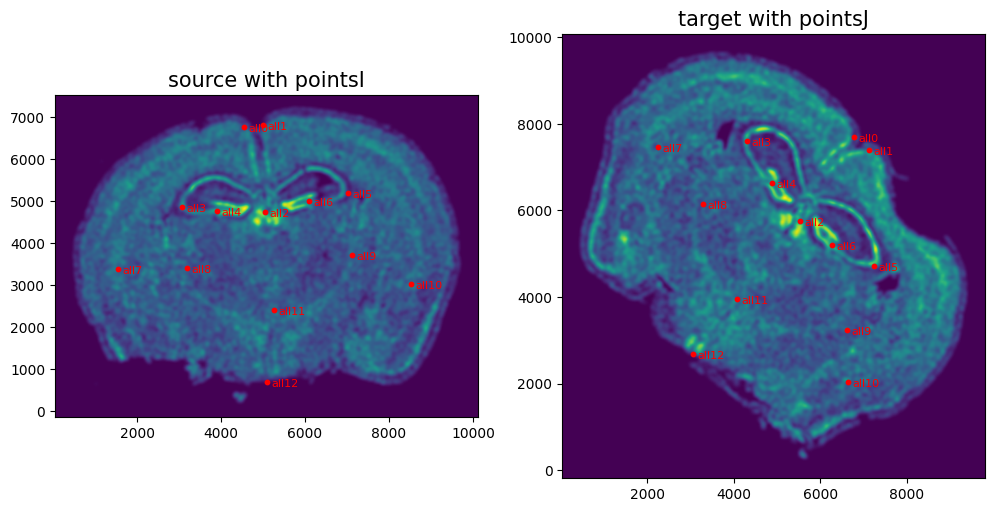

In [15]:
# plot

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=10)
    
for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        ax[0].text(pointsIlist[i][j][0], pointsIlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        ax[1].text(pointsJlist[i][j][0], pointsJlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

# invert only rasterized images
ax[0].invert_yaxis()
ax[1].invert_yaxis()

From the landmark points, we can generate a linear transformation `L` and translation `T` which will produce a simple initial affine transformation `A`. 

In [16]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [17]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI,pointsJ)
A = STalign.to_A(torch.tensor(L),torch.tensor(T))

/home/kalen/.local/share/virtualenvs/STalign-VWNsoi3D/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


We can show the results of the simple affine transformation on the rasterized source image.

/home/kalen/.local/share/virtualenvs/STalign-VWNsoi3D/lib/python3.8/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


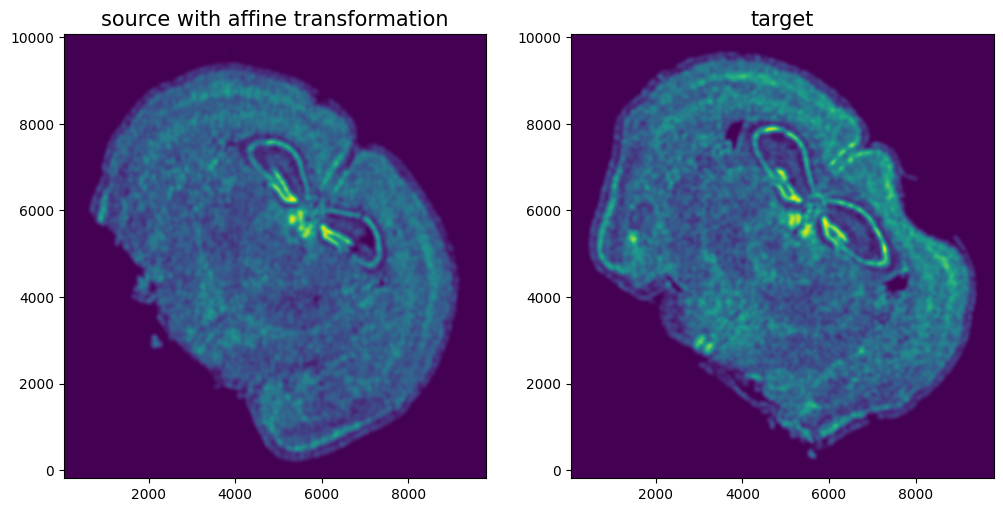

In [18]:
# compute initial affine transformation from points
AI= STalign.transform_image_atlas_with_A(A, [YI,XI], I, [YJ,XJ])

fig,ax = plt.subplots(1,2)

if AI.is_cuda:
    ax[0].imshow((AI.cpu().permute(1,2,0).squeeze()), extent=extentJ) 
else:
    ax[0].imshow((AI.permute(1,2,0).squeeze()), extent=extentJ) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 

ax[0].set_title('source with affine transformation', fontsize=15)
ax[1].set_title('target', fontsize=15)

# invert only rasterized images
ax[0].invert_yaxis()
ax[1].invert_yaxis()

Finally, we can apply our affine transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [19]:
#apply A to sources points in row, column (y,x) orientation
affine = np.matmul(np.array(A.cpu()),np.array([yI, xI, np.ones(len(xI))]))

xIaffine = affine[1,:] 
yIaffine = affine[0,:]

And we can visualize the results.

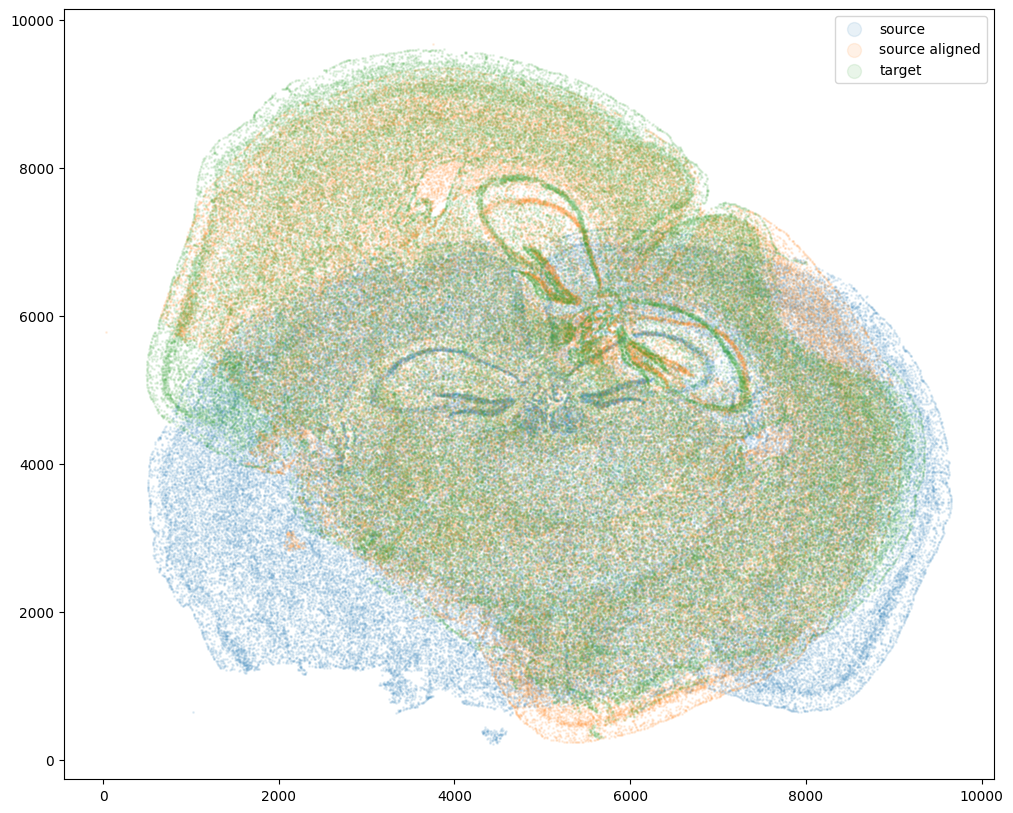

In [20]:
# plot results
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xIaffine,yIaffine,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

And save the new aligned positions by appending to our original data

In [22]:
df3 = pd.DataFrame(

    {

        "aligned_x": xIaffine,

        "aligned_y": yIaffine,

    },


)

results = pd.concat([df1, df3], axis=1)
results.head()

Unnamed: 0  fov       volume    center_x   
0  158338042824236264719696604356349910479   33   532.778772  617.916619  \
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y    aligned_x   
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810  1144.886231  \
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812  1197.052502   
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812  1174.838094   
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812  1182.723315   
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810  1152.710375   

     aligned_y  
0  7614.195863  
1  7703.386882  
2  7706.104535  
3  7724.233148  
4  7637.229823

We will finally create a compressed `.csv.gz` file named `mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Slice2_Replicate2.csv.gz`

In [24]:
results.to_csv('../merfish_data/mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Slice2_Replicate2_affine_only_with_points.csv.gz',
               compression='gzip')